# Truncated SVD

In [45]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt

% matplotlib inline

We begin by reading the A, B, G matrices following the instructions of the readme.txt file. We slice the initial dataframe into 3 parts and then convert to numpy arrays with the correct dimensions. It should be noted that, although G is a matrix representing the blurred image, we need it in vector form to preserve the correct dimensinality in the calculations.

In [46]:
data = pd.read_csv('data.txt', sep=" ", header=None).iloc[:,:-1]
m = data.shape[0]
A = data.loc[:m/3-1,:].as_matrix().reshape(256,256)
B = data.loc[m/3:2/3*m-1,:].as_matrix().reshape(256,256)
G = data.loc[2/3*m:,:].as_matrix().reshape(256*256,1)

We will not attempt to calculate the Kronecker product, K, of A and B, since it would probably not fit in memory and the calculations would be too slow. Instead, we are going to construct an algorithm which takes advantage of Theorem 1 found in the project's notes and calculates the U, Σ, V matrices of K that derive from performing an SVD decomposition on it, based on the SVD outcome of the smaller matrices A & B. This is crucial both for memory management and running time.

First we need to perform the SVD decomposition on the A & B and store the corresponding matrices. We note that the V matrices need to be transposed and the S matrices are stored in diagonal form, because that's how they will fit in the get_svd_vector function defined below.

In [47]:
U_A, S_A, V_A = svd(A)
U_B, S_B, V_B = svd(B)

V_A = V_A.T
V_B = V_B.T

S_A = np.diag(S_A)
S_B = np.diag(S_B)

We can see that in the solution of the Least Squares problem in outer product form we only need the i-th column of the 'big' U and V matrices (meaning the U and V resulting from K's SVD decomposition). 

The following function takes as input any of the SVD output matrices and the integer i, which is the desired column, and returns this exact column. This column can be found from the Kronecker product of the small matrices (meaning the matrices U, V or Σ produced from the SVD decomposition of A or B), but we first need to make sure we select the right columns from each small matrix. It is easy to see that the rule for selecting the correct column from the small matrix that corresponds to A is $i // m$, where i is the desired column of the big matrix and m is the dimension of the small matrices, since they are both square matrices. The rule for selecting the correct column from the small matrix that corresponds to B is $ i \% m $.

For example, for 3x3 A and B matrices, if we need the 7th column of the big U, we would need $7//3 = 2$ column of uA and $7\%3=1$ column of uB, which correspond to the 3rd and the 2nd column of uA and uB, respectively in Python indexing.

The same reasoning is followed for V. In the case of Σ, however, we need to note that the Kronecker product will not produce a sorted diagonal, which means that the singular values of K will not be sorted as they should.

In [48]:
# Takes U, V or Σ of A and B and returns the i'th column of the corresponding SVD matrix of their Kronecker product

def get_svd_vector(matrixof_svd_A, matrixof_svd_B, i):
    # for u and v matrices from SVD
    m = 256
    matrix_i = np.outer(matrixof_svd_A[:, i // m], matrixof_svd_B[:,i % m].T).reshape([m**2,1])
    return matrix_i

In [49]:
# Defines n based on A dimensions
n = A.shape[0]

# Constructs Σ matrix
S_matrix = []
for i in range(n**2):
    S_matrix.append(get_svd_vector(S_A, S_B, i)[i][0])
    
# Determines the indices of the first k largest singular values
S_matrix = np.array(S_matrix)
k = 2900                                                 # The value of k selected after tuning
k_indices = S_matrix.argsort()[-k:][::-1]                     # This is the sorting step! We do not sort per se, but rather
                                                              # find the indices of S_matrix where 
                                                              # the largest singular values lie.
                                                              # We need those indices to select the correct columns from U and V
# Takes k largest singular values
S_values = S_matrix[k_indices]  

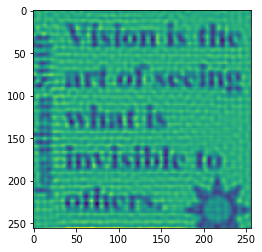

In [50]:
# f calculation with Truncated SVD
f1 = np.zeros(n**2).reshape(n**2,1)        # Initializes a zero f vector

for k in k_indices:                        # Estimates the sum for the hyperparameter k we selected (k largest singular values)
    uk = get_svd_vector(U_A, U_B, k)       # Since we sorted Σ, we now need to select the right columns from U and V
    vk = get_svd_vector(V_A, V_B, k)
    s = S_matrix[k]                        # Selects the correct (largest) singular values of Σ
    f1 += np.dot(uk.T, G)/s * vk
                 
 
f1 = f1.reshape([256, 256])                # Reshapes f vector to a 256x256 matrix and prints the image
plt.imshow(f1)

# Tikhonov regularization

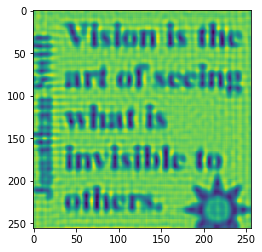

In [51]:
asquared = 0.000001                                   # The value of a squared selected after tuning
                                                      # Since we now take the sum for all singular values, we do not need sorting
                                                      # and index selection
f2 = np.zeros(n**2).reshape(n**2,1)
for i in range(n**2):
    uk = get_svd_vector(U_A, U_B, i)
    vk = get_svd_vector(V_A, V_B, i)
    s = S_matrix[i]
    f2 += s * np.dot(uk.T, G)/(s**2+asquared) * vk    # The only difference is that we run for all singular values and normalize 
                                                      # with a to give different weight to singular values 
                                                      # based on their importance
f2 = f2.reshape([256, 256])
imshow(f2)

We do not expect to reach the same exact output image, since the two methods have a different effect on the singular values. The first one keeps a very small subset of them, while the second one preserves all singular values but alters them slightly with the addition of a squared.